## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [2]:
plt.style.use('seaborn-v0_8')
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv("../data/raw/train.csv")

In [4]:
print("Shape:", df.shape)
display(df.head())

print("\nInfo:")
print(df.info())

display(df.describe().T)

Shape: (159256, 24)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL       

,count,mean,std,min,25%,50%,75%,max
id,159256.0,79627.500000,45973.391572,0.0,39813.75,79627.5,119441.25,159255.0
age,159256.0,44.306626,11.842286,20.0,40.00,40.0,55.00,85.0
height(cm),159256.0,165.266929,8.818970,135.0,160.00,165.0,170.00,190.0
weight(kg),159256.0,67.143662,12.586198,30.0,60.00,65.0,75.00,130.0
waist(cm),159256.0,83.001990,8.957937,51.0,77.00,83.0,89.00,127.0
eyesight(left),159256.0,1.005798,0.402113,0.1,0.80,1.0,1.20,9.9
eyesight(right),159256.0,1.000989,0.392299,0.1,0.80,1.0,1.20,9.9
hearing(left),159256.0,1.023974,0.152969,1.0,1.00,1.0,1.00,2.0
hearing(right),159256.0,1.023421,0.151238,1.0,1.00,1.0,1.00,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.00,121.0,130.00,213.0


## 🧩 Промежуточный итог: Общее представление о данных

**Размер датасета:** 159 256 строк × 24 признака
**Типы данных:** 19 `int64`, 5 `float64`
**Пропуски:** отсутствуют ✅

---

### ⚙️ Структура данных
- Демографические: `age`, `height(cm)`, `weight(kg)`, `waist(cm)`
- Физиологические: `systolic`, `relaxation`, `hearing`, `eyesight`
- Биохимические: `Cholesterol`, `LDL`, `HDL`, `triglyceride`, `AST`, `ALT`, `Gtp`
- Целевая переменная: **`smoking` (0 – не курит, 1 – курит)**

---

### 🚨 Потенциальные проблемы
- **Выбросы**: `LDL`, `triglyceride`, `ALT`, `AST`, `Gtp` имеют экстремальные значения (до 1000+)
- **Технические капы**: значения `9.9` в `eyesight` и `serum creatinine`
- **Классовый баланс:** 0 ≈ 56 %, 1 ≈ 44 % → допустимо, но требует стратификации

---

### 💡 Предварительные гипотезы
- Курильщики чаще имеют ↑ `Gtp`, `ALT`, `LDL`, `triglyceride` и ↓ `HDL`
- Возможна слабая зависимость от возраста и давления

---

## 2. Анализ данных

,missing,missing_%


,count,pct
smoking,,
0,89603,56.26
1,69653,43.74


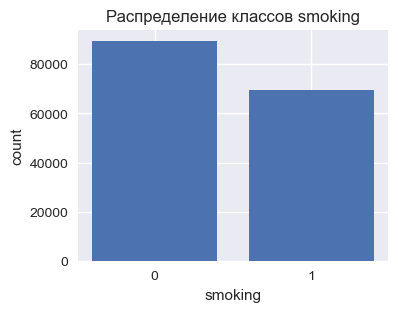

In [5]:
# Пропуски
na = df.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing": na, "missing_%": (na/len(df)*100).round(2)}).query("missing>0"))

# Дисбаланс классов
cls = df["smoking"].value_counts().sort_index()
display(pd.DataFrame({"count": cls, "pct": (cls/len(df)*100).round(2)}))
plt.figure(figsize=(4,3)); plt.bar(cls.index.astype(str), cls.values)
plt.title("Распределение классов smoking"); plt.xlabel("smoking"); plt.ylabel("count"); plt.show()

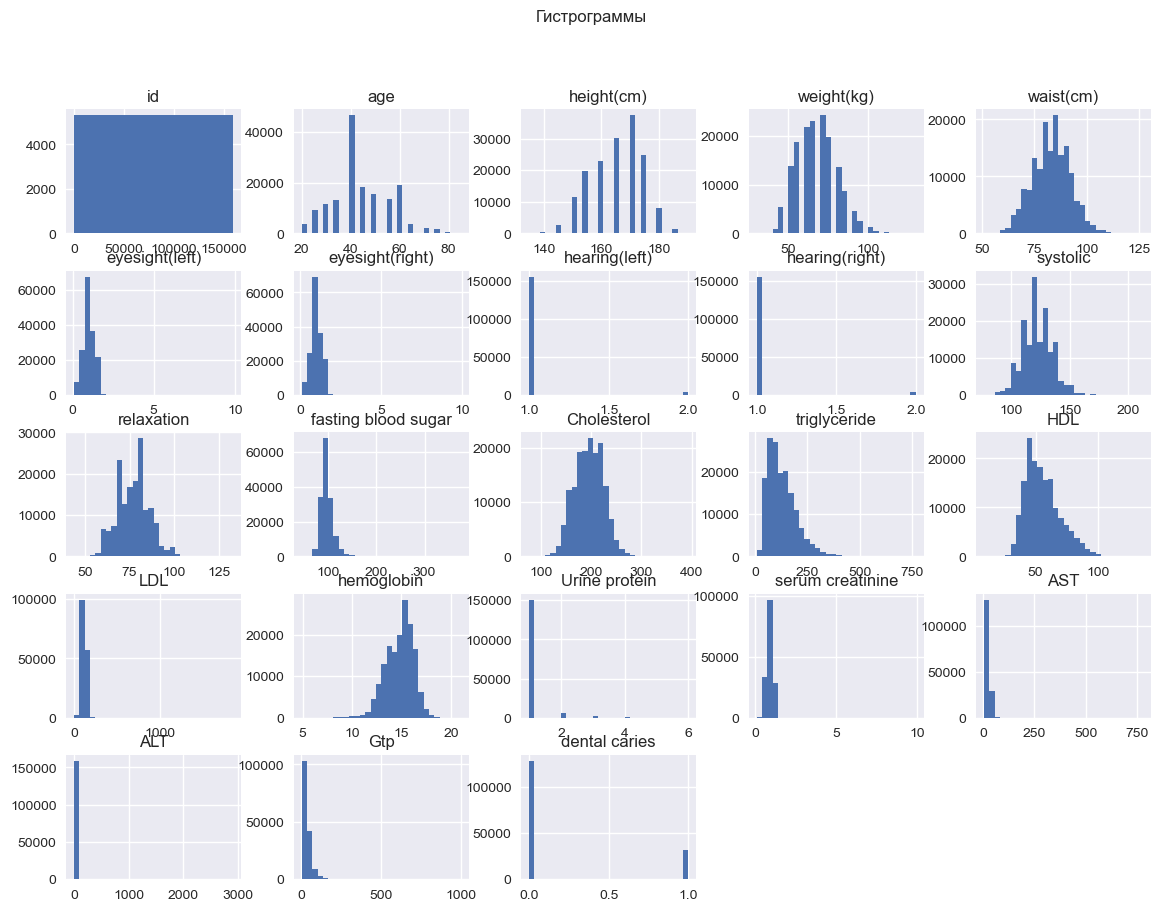

In [6]:
num_cols = df.select_dtypes(include=np.number).columns.drop("smoking")
df[num_cols].hist(bins=30, figsize=(14,10)); plt.suptitle("Гистрограммы"); plt.show()

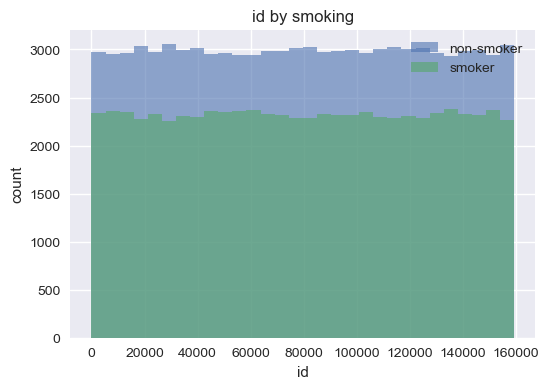

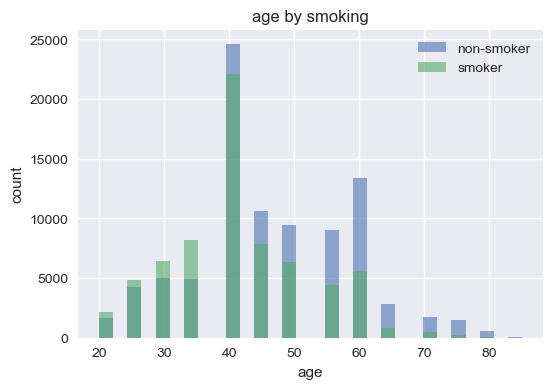

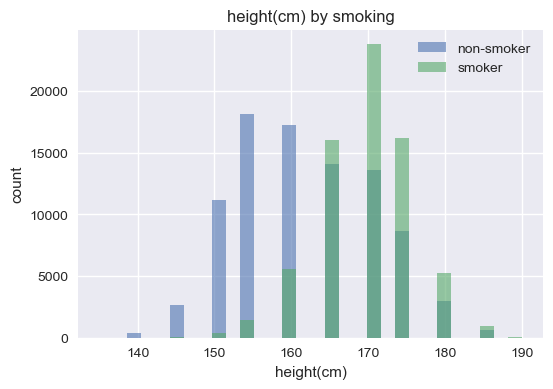

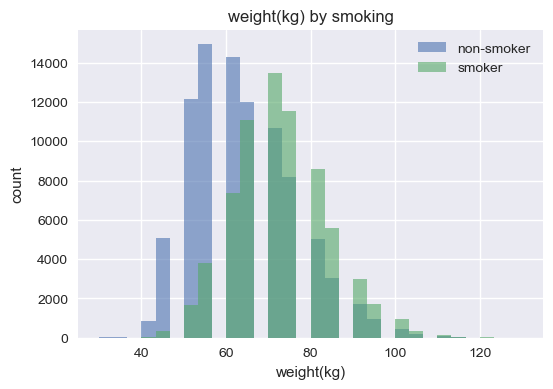

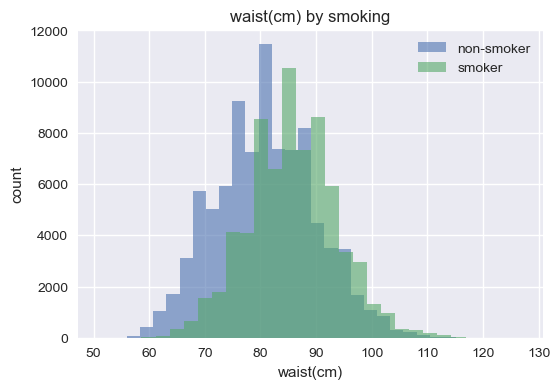

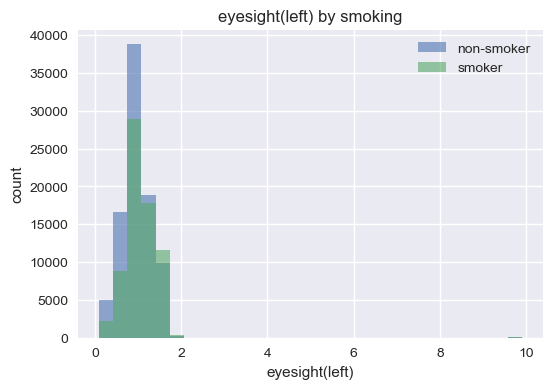

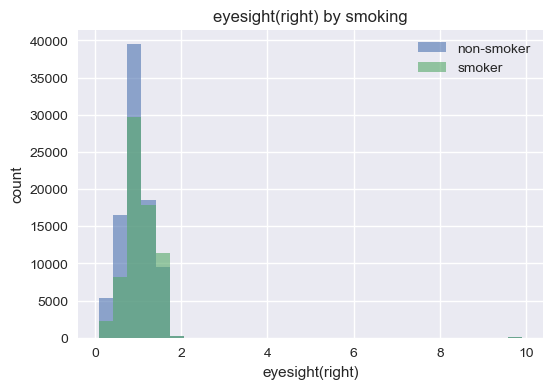

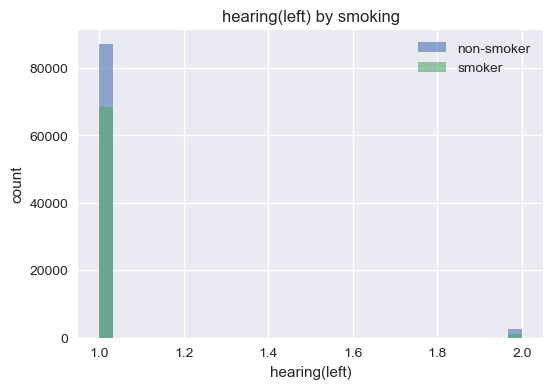

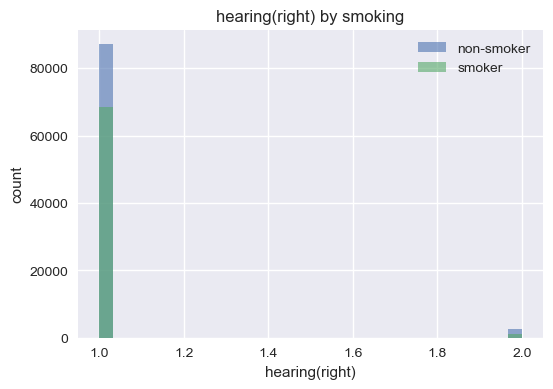

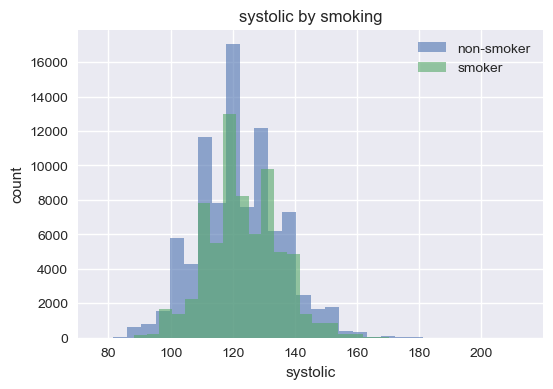

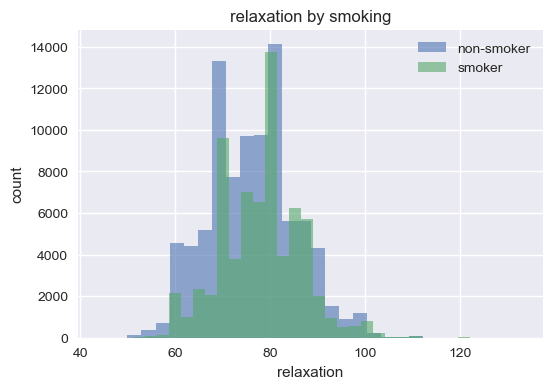

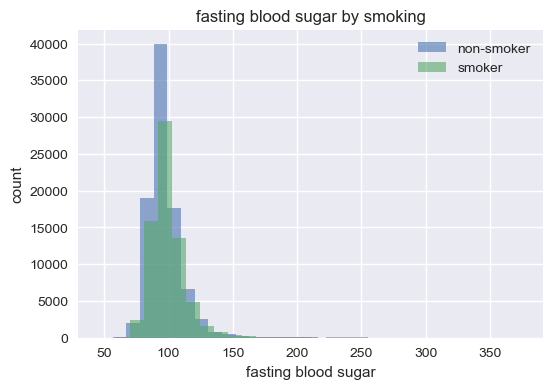

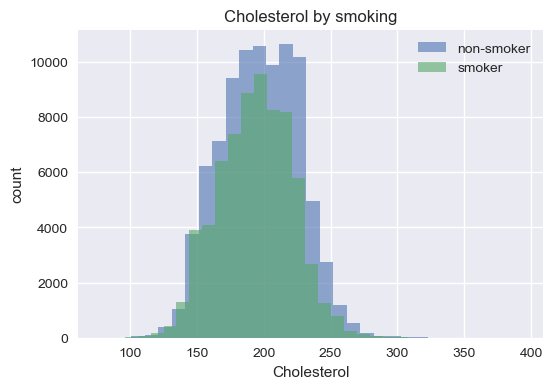

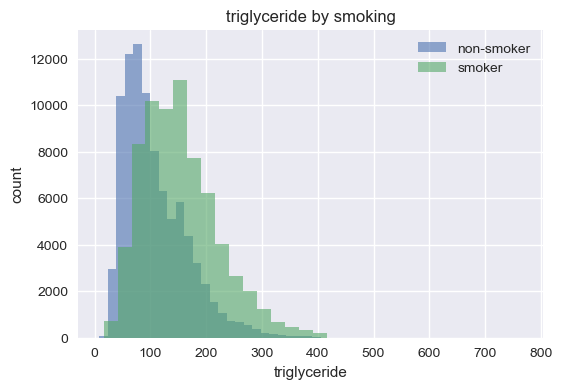

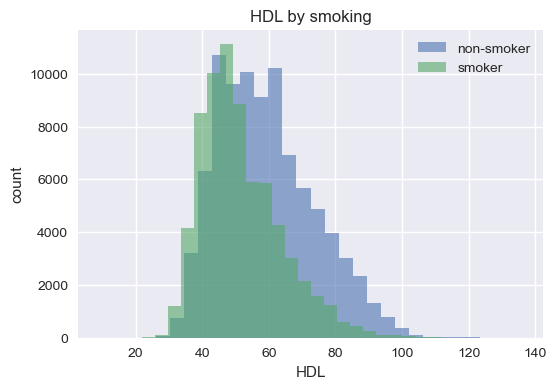

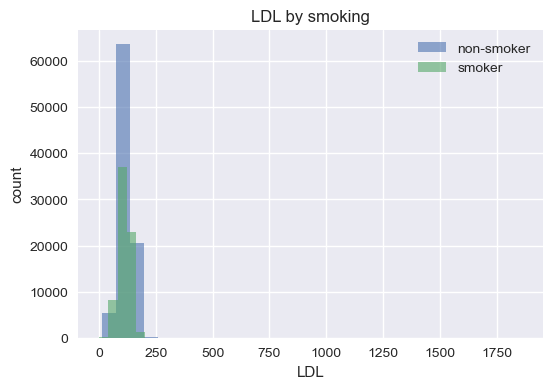

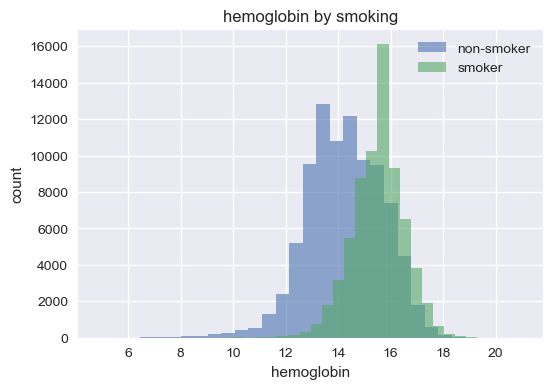

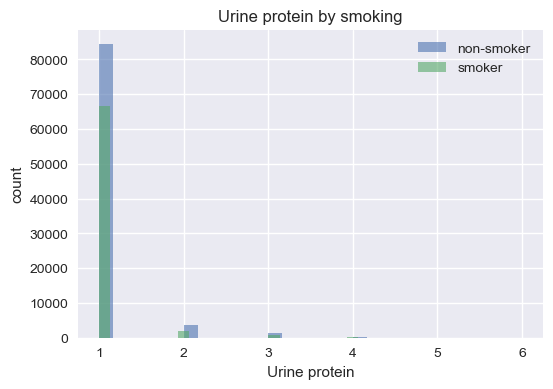

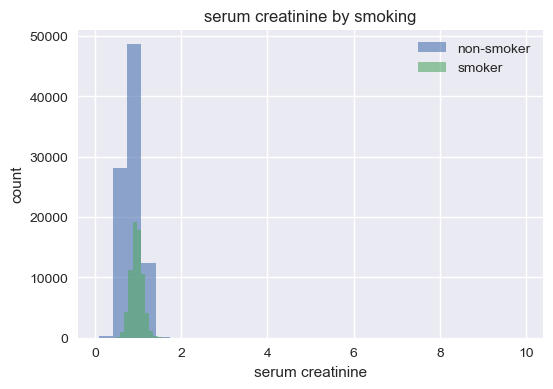

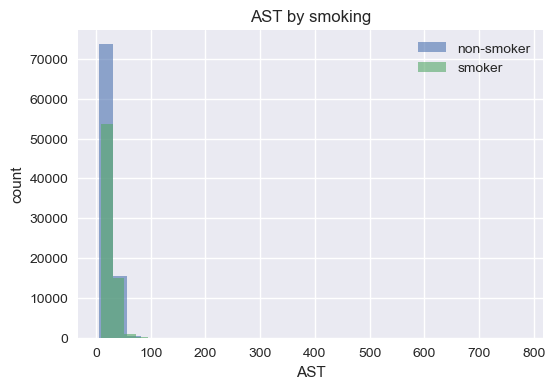

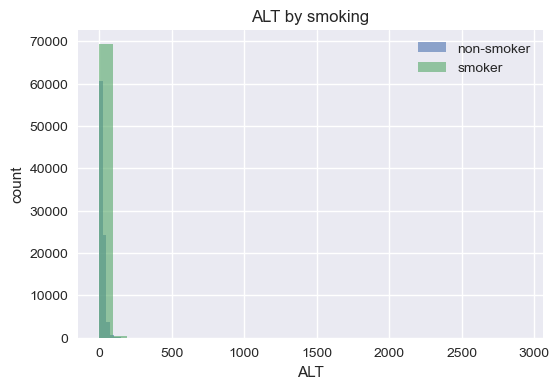

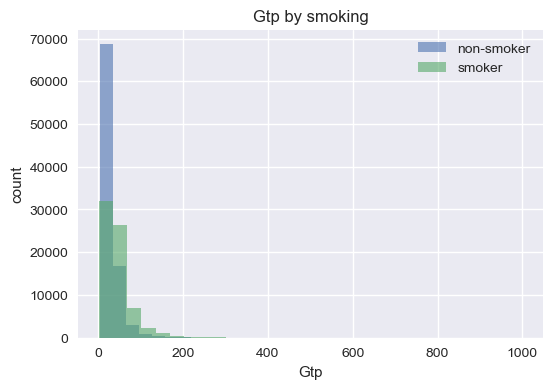

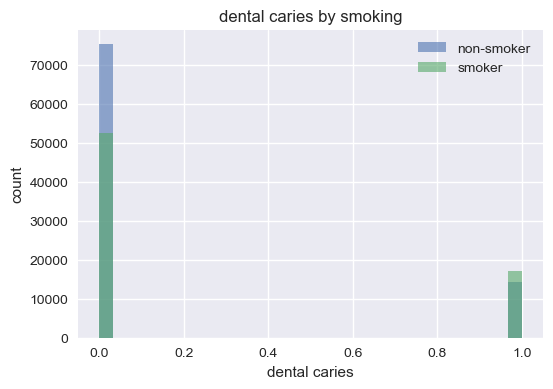

In [7]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[df["smoking"]==0][col], bins=30, alpha=0.6, label="non-smoker")
    plt.hist(df[df["smoking"]==1][col], bins=30, alpha=0.6, label="smoker")
    plt.title(f"{col} by smoking"); plt.xlabel(col); plt.ylabel("count"); plt.legend(); plt.show()


### Наблюдения по гистограммам
- **Возраст, рост:** формы близки, заметных сдвигов нет.
- **Вес и талия:** у курильщиков распределения немного смещены вправо → чуть выше масса и окружность талии.
- **Давление (systolic/relaxation):** у курильщиков пик правее → в среднем выше давление.
- **Глюкоза натощак:** различия минимальны.
- **Липиды:**
  - **triglyceride** — у курильщиков явный правый сдвиг (больше высоких значений).
  - **LDL** — правый хвост длиннее у курильщиков (разница умеренная).
  - **HDL** — у курильщиков левый сдвиг (ниже HDL).
  - **Cholesterol** — лёгкий правый сдвиг.
- **Печёночные ферменты:** **Gtp**, **ALT**, **AST** выраженно скошены вправо, у курильщиков больше высоких значений.
- **Hemoglobin:** у курильщиков чуть выше.
- **Urine protein, hearing, eyesight:** различия небольшие; hearing = 1 доминирует, eyesight и creatinine имеют технический «потолок» **9.9**.

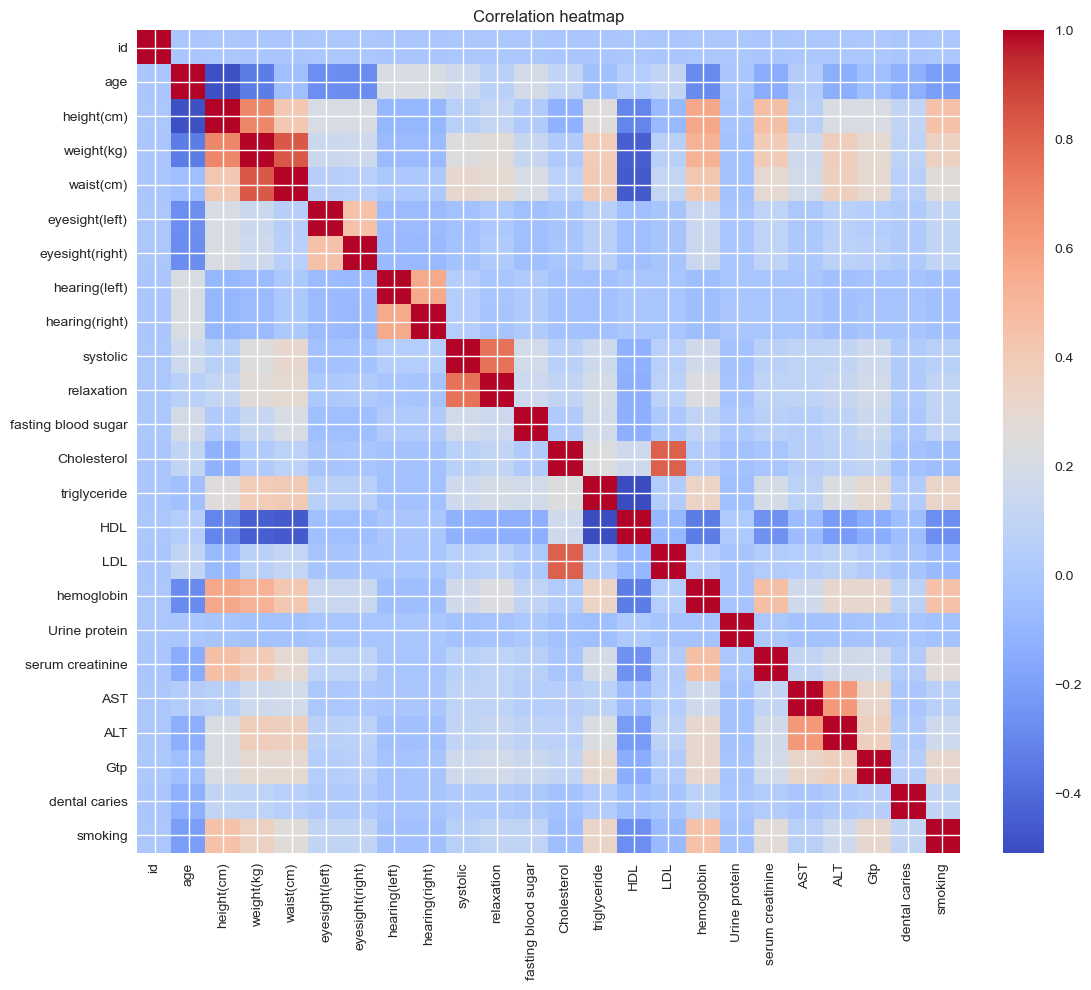

,corr_with_smoker
hemoglobin,0.450679
height(cm),0.447111
weight(kg),0.351748
triglyceride,0.331975
Gtp,0.305561
serum creatinine,0.272979
HDL,-0.271186
waist(cm),0.262715
age,-0.206033
ALT,0.163016


In [8]:
corr = df[num_cols.tolist()+["smoking"]].corr(numeric_only=True)

plt.figure(figsize=(12,10))
im = plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap"); plt.colorbar(im, fraction=0.046, pad=0.04); plt.tight_layout(); plt.show()

target_corr = corr["smoking"].drop("smoking").sort_values(key=lambda s: s.abs(), ascending=False)
display(target_corr.to_frame("corr_with_smoker").head(20))


### Топ-связи с `smoking` (по |corr|):
- **Положительные:** `hemoglobin (0.45)`, `height (0.45)`, `weight (0.35)`, `triglyceride (0.33)`, `Gtp (0.31)`, `serum creatinine (0.27)`, `waist (0.26)`, `ALT (0.16)`.
- **Отрицательные:** `HDL (-0.27)`, `age (-0.21)`, `LDL (-0.07)` (слабо).

### Интерпретация и важное замечание
- Сильные корреляции `hemoglobin` и `height` почти наверняка выступают **прокси пола** (в датасете нет колонки sex). Вероятно, в данных **мужчины чаще курят**, поэтому модели будут сильно опираться на эти признаки. Это повышает качество, но несёт риск **смещения/непереносимости**.
- Биохимические маркеры согласуются с ожиданиями: у курильщиков ↑ `Gtp`, `ALT`, `triglyceride` и ↓ `HDL`.

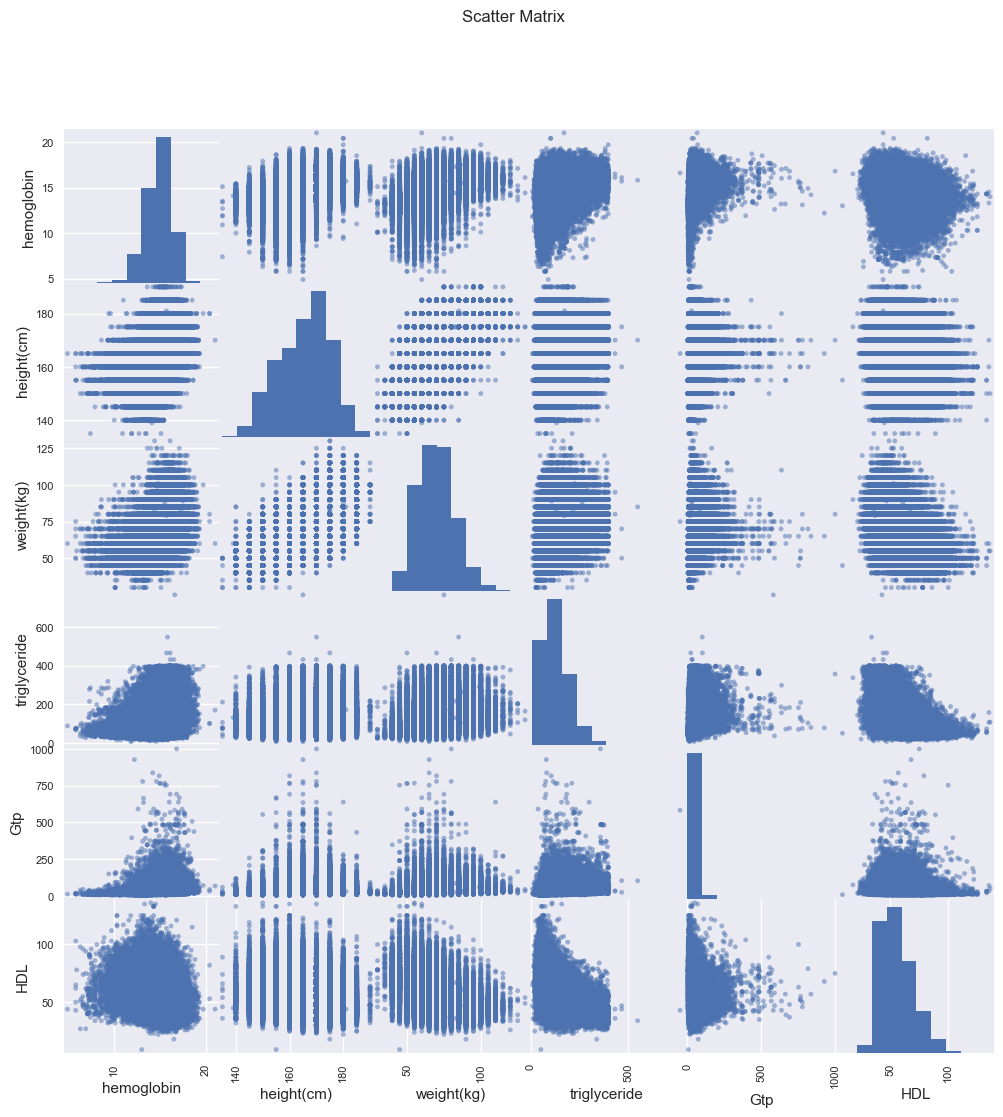

In [9]:
top = ['hemoglobin','height(cm)','weight(kg)','triglyceride','Gtp','HDL']
_ = scatter_matrix(df[top], figsize=(12,12), diagonal='hist')
plt.suptitle('Scatter Matrix'); plt.show()

### Наблюдения
- **Hemoglobin ↔ height/weight:** выраженная положительная зависимость (ожидаемо, отражает физические различия, вероятно, связанные с полом).
- **Triglyceride ↔ Gtp:** видна положительная зависимость, возможный общий фактор метаболического синдрома.
- **HDL** демонстрирует обратную зависимость к `triglyceride` и частично к `Gtp`.

### Выводы
- Scatter matrix подтверждает **корреляции из тепловой карты**.
- Есть выраженные **линейные кластеры**, особенно для антропометрических признаков.
- В данных заметны **плотные вертикальные полосы** — это результат **округления значений** в исходных измерениях (медицинские данные часто дискретизируются).
- Признаки выглядят разумно распределёнными, значимых выбросов не видно, кроме длинных хвостов у `triglyceride` и `Gtp`.

### Что дальше
→ Проверим количественно выбросы по IQR и Z-score, чтобы подтвердить хвостовые значения.
→ После этого сформируем **итог по выбросам и feature engineering** (BMI, WHtR, PulsePressure, лог-преобразования и т.д.).

In [10]:
out_iqr, out_z = defaultdict(dict), defaultdict(dict)
for c in num_cols:
    s = df[c].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75); iqr = q3-q1
    low, high = q1-1.5*iqr, q3+1.5*iqr
    out_iqr[c]["iqr_low"], out_iqr[c]["iqr_high"] = (s<low).sum(), (s>high).sum()
    m, sd = s.mean(), s.std(ddof=0)
    out_z[c]["z_abs>3"] = 0 if sd==0 else (((s-m).abs()/sd) > 3).sum()

out_tbl = (pd.DataFrame(out_iqr).T.rename(columns={"iqr_low":"iqr_low_outliers","iqr_high":"iqr_high_outliers"})
           .join(pd.DataFrame(out_z).T)).fillna(0).astype(int)
display(out_tbl.sort_values(["iqr_high_outliers","iqr_low_outliers","z_abs>3"], ascending=False).head(20))

,iqr_low_outliers,iqr_high_outliers,z_abs>3
dental caries,0,31532,0
Gtp,0,8792,2722
Urine protein,0,8394,2785
fasting blood sugar,346,7814,2159
ALT,0,6746,1689
AST,1,6336,1719
hearing(left),0,3818,3818
hearing(right),0,3730,3730
triglyceride,0,3087,1679
serum creatinine,2960,2983,281


## 🚨 Промежуточный итог: Выбросы (IQR & Z>3)

**Наиболее проблемные сверху (по IQR_high / Z>3):**
- `Gtp` **(8792 IQR_high, 2722 Z>3)** — длинный правый хвост.
- `ALT` **(6746 / 1689)**, `AST` **(6336 / 1719)** — сильная правоскошность.
- `triglyceride` **(3087 / 1679)** — выраженный хвост.
- `fasting blood sugar` **(7814 / 2159)** — заметные высокие значения.
- `serum creatinine` — **двусторонние** выбросы (2960 low, 2983 high) → подозрение на технический cap 9.9.
- `HDL`, `weight(kg)`, `waist(cm)`, `BP` — умеренные хвосты.

**Почему тут так много:**
- `dental caries` (0/1), `hearing(left/right)` (1/2), `Urine protein` (1..6) — **дискретные/категориально-ординальные** признаки. IQR у них «наказывает» крайние уровни, но это **не ошибка** данных.

**Выводы**
- Сильно правоскошные: **Gtp, ALT, AST, triglyceride, fasting blood sugar** → лог-преобразование.
- Двусторонние выбросы: **serum creatinine** → клиппинг по квантилям; проверить долю тех.значения **9.9**.
- Дискретные (`dental caries`, `hearing*`, `Urine protein`) **не клиппуем**, обрабатываем как категориальные/ординальные.


In [11]:
for c in ['serum creatinine','eyesight(left)','eyesight(right)']:
    cap99 = (df[c] >= 9.9).mean()*100
    print(f"{c}: доля значений >= 9.9 = {cap99:.3f}%")

serum creatinine: доля значений >= 9.9 = 0.001%
eyesight(left): доля значений >= 9.9 = 0.083%
eyesight(right): доля значений >= 9.9 = 0.073%


## ✅ Проверка технических «каповых» значений (9.9)

- `serum creatinine ≥ 9.9`: **0.001%**
- `eyesight(left) ≥ 9.9`: **0.083%**
- `eyesight(right) ≥ 9.9`: **0.073%**

**Вывод:** доли ничтожны → не влияют на распределения.
**Действие:** можно оставить как есть **или** аккуратно клипповать по верхнему квантилю (например, 99.5%), чтобы не мешали масштабированию.

In [12]:
fe = df.copy()
fe["BMI"] = fe["weight(kg)"]/(fe["height(cm)"]/100)**2
fe["WHtR"] = fe["waist(cm)"]/fe["height(cm)"]
fe["PulsePressure"] = fe["systolic"] - fe["relaxation"]
fe["non_HDL"] = fe["Cholesterol"] - fe["HDL"]
fe["LDL_to_HDL"] = fe["LDL"]/fe["HDL"].replace(0, np.nan)
fe["TG_to_HDL"]  = fe["triglyceride"]/fe["HDL"].replace(0, np.nan)
fe["AST_to_ALT"] = fe["AST"]/fe["ALT"].replace(0, np.nan)
for c in ["triglyceride","Gtp","ALT","AST"]:
    fe[f"log_{c}"] = np.log1p(fe[c])

fe[["BMI","WHtR","PulsePressure","LDL_to_HDL","TG_to_HDL","AST_to_ALT"]].describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,159256.0,24.452825,3.368651,11.718750,22.222222,24.221453,26.159334,45.785640
WHtR,159256.0,0.502491,0.050137,0.300000,0.468571,0.500000,0.535172,0.793750
PulsePressure,159256.0,45.629578,8.396904,-7.000000,40.000000,45.000000,50.000000,131.000000
LDL_to_HDL,159256.0,2.183459,0.750977,0.021739,1.653061,2.142857,2.660714,39.574468
TG_to_HDL,159256.0,2.579325,1.745235,0.123077,1.240506,2.150943,3.489796,18.777778
AST_to_ALT,159256.0,1.111938,0.435729,0.010638,0.818182,1.062500,1.333333,43.000000


## Итог по Feature Engineering

**Сводка (describe):**
- **BMI**: средн. 24.45 (Q1–Q3 ≈ 22.22–26.16) — реалистично.
- **WHtR**: средн. 0.502 (Q1–Q3 ≈ 0.469–0.535) — типичные значения.
- **PulsePressure**: средн. 45.6; min = **–7** → единичные аномалии измерений (редкие).
- **LDL_to_HDL**: средн. 2.18, **max 39.57** (деление на очень малый HDL) → выбросы-отношения.
- **TG_to_HDL**: средн. 2.58, **max 18.78** → аналогично, хвост.
- **AST_to_ALT**: средн. 1.11, **max 43** → при очень малом ALT.

**Выводы и действия**
- Отношения имеют длинные хвосты из-за маленького знаменателя → перед моделями:
  1) заменить нули в знаменателях на малое число/NaN (ты сделал `replace(0, np.nan)` — ок),
  2) **клиппинг верхних квантилей** (напр., 99.5%) для `LDL_to_HDL`, `TG_to_HDL`, `AST_to_ALT`,
  3) скорректировать редкие отрицательные `PulsePressure` (клиппинг ≥0).

# Baseline-модель

## Подготовить данные для модели

- **Выделить X и Y**
- **Масштабировать признаки**
- **Разделить выборку train/test**
- **Учесть дисбаланс классов (class_weight="balanced")**

## Построить LogisticRegression

- **Обучить модель на данных из train**
- **Получить предсказания для тестовых данных**
- **Вычислить основные метрики: Accuracy, Precision, Recall, F1-score, ROC-AUC**

## Провести кросс-валидацию

- **Использовать 5-fold cross-validation для получения устойчивой оценки качества. Оценивать F1-score и/или ROC-AUC**

## Сравнить результаты CV на трейне и валидации

- **Проверить переобучение / недообучение**
- **Убедиться, что модель работает стабильно**

## Написать вывод

- **Насколько baseline моделирует целевой признак**
- **Какие признаки оказались наиболее значимыми**
- **Есть ли проблемы: дисбаланс, шум, отсутствие информации в данных**

In [50]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, ElasticNet
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline

### Разделение датасета на обучающую и тестовую выборки без стратификации

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    fe.drop('smoking', axis=1),
    fe['smoking'],
    random_state=42
)

### ⚖️ Сравнение баланса классов в сформированных выборках

Text(0.5, 1.0, 'Тестовая выборка')

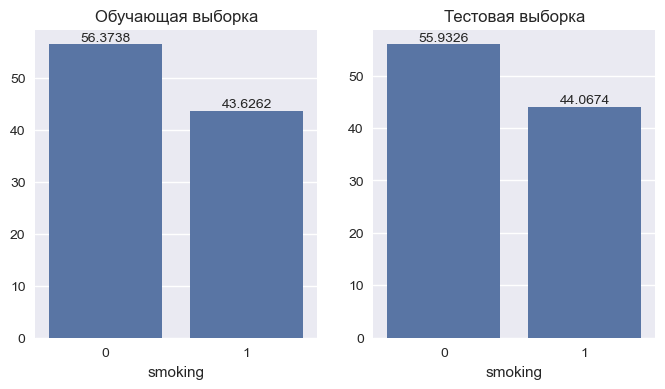

In [15]:
# Вычисляем отношения классов в сформированных выборках
train_class_ratios = y_train.value_counts(normalize=True) * 100
test_class_ratios = y_test.value_counts(normalize=True) * 100

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x=train_class_ratios.index, y=train_class_ratios.values, ax=axs[0])
axs[0].bar_label(axs[0].containers[0], fontsize=10)
axs[0].set_title('Обучающая выборка')

sns.barplot(x=test_class_ratios.index, y=test_class_ratios.values, ax=axs[1])
axs[1].bar_label(axs[1].containers[0], fontsize=10)
axs[1].set_title('Тестовая выборка')

Можем заметить, что между классами в обучающей и тестовой выборке есть незначительный дисбаланс (< 0.5).
Воспользуемся методом стратификации при формировании выборок для минимизации дисбаланса

### Разделение датасета на обучающую и тестовую выборки с использованием стратификации

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    fe.drop('smoking', axis=1),
    fe['smoking'],
    random_state=42,
    stratify=fe['smoking']
)

### ⚖️ Сравнение баланса классов в сформированных выборках

Text(0.5, 1.0, 'Тестовая выборка')

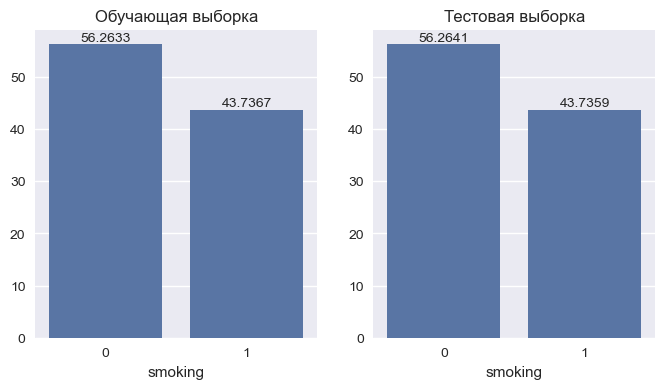

In [27]:
# Вычисляем отношения классов в сформированных выборках
train_class_ratios = y_train.value_counts(normalize=True) * 100
test_class_ratios = y_test.value_counts(normalize=True) * 100

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x=train_class_ratios.index, y=train_class_ratios.values, ax=axs[0])
axs[0].bar_label(axs[0].containers[0], fontsize=10)
axs[0].set_title('Обучающая выборка')

sns.barplot(x=test_class_ratios.index, y=test_class_ratios.values, ax=axs[1])
axs[1].bar_label(axs[1].containers[0], fontsize=10)
axs[1].set_title('Тестовая выборка')

В результате применения стратификации нам удалось сократить дисбаланс между классами до 0.01, что позволит улучшить объективность метрик нашей модели на сформированных выборках

### 🎓 Формирование пайплайна и обучение модели (без балансировки классов)

In [95]:
pipeline = make_pipeline(
  StandardScaler(),
  LogisticRegression(random_state=42, max_iter=1000)
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

### 📚 Кросс-валидация методом K-Fold без стратификации

In [96]:
# Создаем KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_metrics = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=['f1', 'roc_auc'],
    return_train_score=True,
    n_jobs=-1
)

df = pd.DataFrame(cv_metrics, index=['1', '2', '3', '4', '5'])
mean_metrics = pd.DataFrame(df.mean(), columns=['Mean']).T
df = pd.concat([df, mean_metrics])

df

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc
1,0.983224,0.030369,0.735428,0.737355,0.842582,0.844296
2,1.105196,0.030951,0.733619,0.737483,0.841511,0.844582
3,1.117809,0.025264,0.736296,0.737430,0.842038,0.844345
4,1.081181,0.026715,0.740579,0.735605,0.849108,0.842620
5,1.105821,0.033248,0.737865,0.737135,0.843539,0.844102
Mean,1.078646,0.029309,0.736757,0.737001,0.843756,0.843989


### 📈 ROC-кривая и матрица ошибок для модели на валидационной выборке (без балансировки классов)

<Axes: >

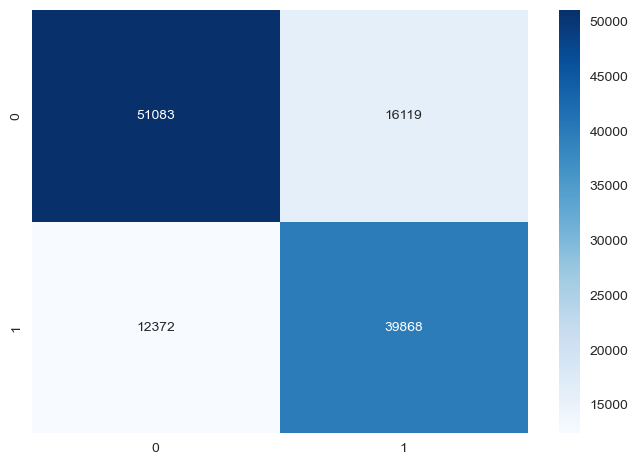

In [97]:
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=kf, n_jobs=-1)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

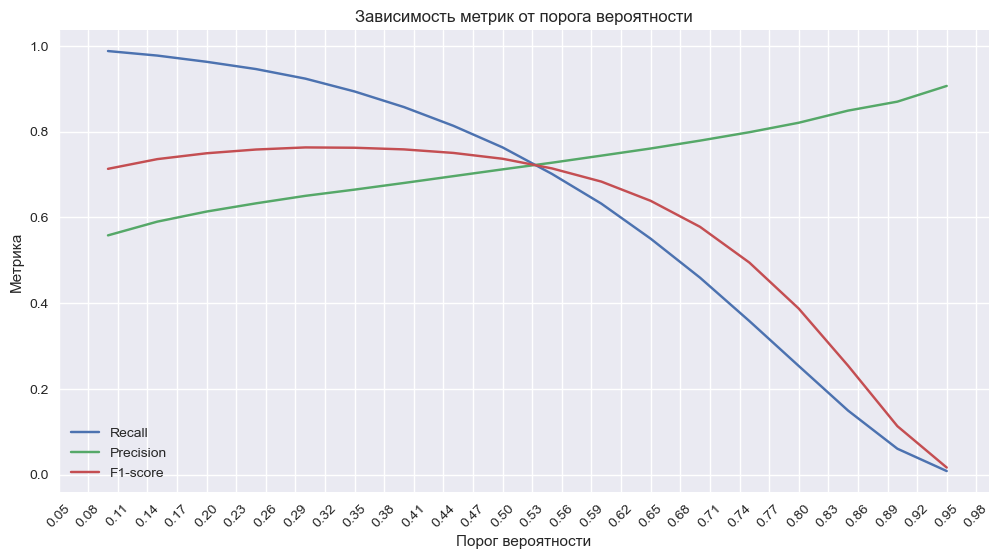

In [99]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Нас интересует только вероятность класса (второй столбец)
y_proba_pred = cross_val_predict(pipeline, X_train, y_train, cv=kf, method='predict_proba')[:, 1]

# Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(recall_score(y_train, y_pred))
    precision_scores.append(precision_score(y_train, y_pred))
    f1_scores.append(f1_score(y_train, y_pred))
    
# Строим линейный график зависимости recall от threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
plt.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
plt.plot(thresholds, f1_scores, label='F1-score')

plt.title('Зависимость метрик от порога вероятности')
plt.xlabel('Порог вероятности')
plt.ylabel('Метрика')
plt.xticks(thresholds)
plt.xticks(np.arange(0.05, 1, 0.03), rotation=45)
plt.grid(True)
plt.legend()

### 📈 ROC-кривая и матрица ошибок для модели на тестовой выборке (без балансировки классов)

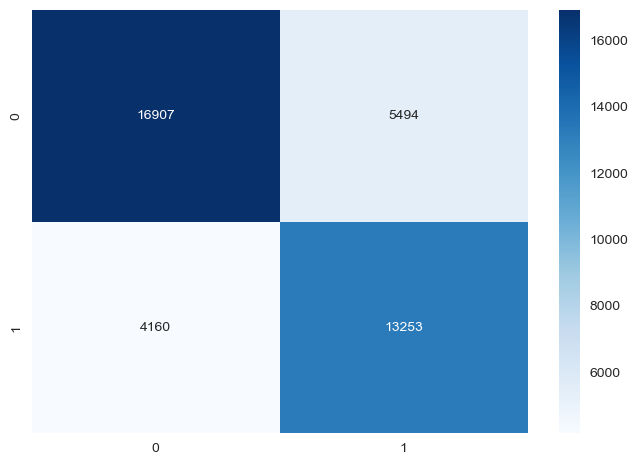

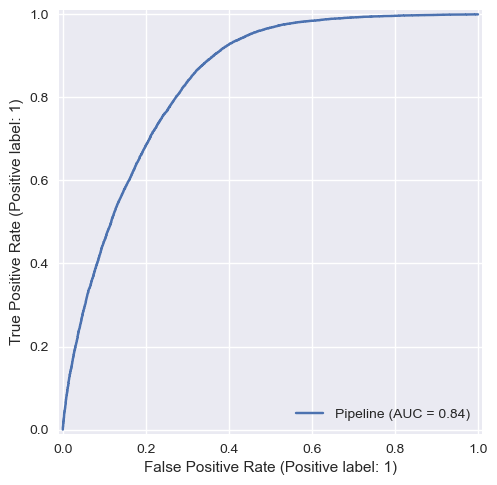

In [77]:
y_pred = pipeline.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

In [83]:
y_true = y_test
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print(f"Accuracy без балансировки классов: {accuracy_score(y_test, y_pred)}")

scores = precision_recall_fscore_support(y_true, y_pred)
scores = pd.DataFrame(scores, index=['Precision', 'Recall', 'F-Score', 'Support'])
scores['Mean'] = scores.mean('columns')

roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

scores

Accuracy без балансировки классов: 0.7575224795298137
ROC-AUC: 0.8410801665808472


,0,1,Mean
Precision,0.802535,0.706940,0.754737
Recall,0.754743,0.761098,0.757921
F-Score,0.777906,0.733020,0.755463
Support,22401.000000,17413.000000,19907.000000


### 🎓 Формирование пайплайна и обучение модели (с балансировкой классов)

In [92]:
pipeline = make_pipeline(
  StandardScaler(),
  LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
)

pipeline.fit(X_train, y_train)
y_true = y_test

### 📚 Кросс-валидация методом Stratified K-Fold

In [93]:
# Создаем StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_metrics = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring=['f1', 'roc_auc'],
    return_train_score=True,
    n_jobs=-1
)

df = pd.DataFrame(cv_metrics, index=['1', '2', '3', '4', '5'])
mean_metrics = pd.DataFrame(df.mean(), columns=['Mean']).T
df = pd.concat([df, mean_metrics])

df

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc
1,0.987505,0.033555,0.752673,0.753146,0.844536,0.843428
2,1.058531,0.018949,0.751586,0.754096,0.839568,0.844675
3,0.899317,0.031648,0.754477,0.753151,0.843262,0.843875
4,0.840919,0.024996,0.751468,0.754374,0.843175,0.843836
5,1.028726,0.018553,0.756160,0.752487,0.846823,0.843014
Mean,0.963000,0.025540,0.753273,0.753451,0.843473,0.843766


### 📈 ROC-кривая и матрица ошибок для модели на валидационной выборке (с балансировкой классов)

<Axes: >

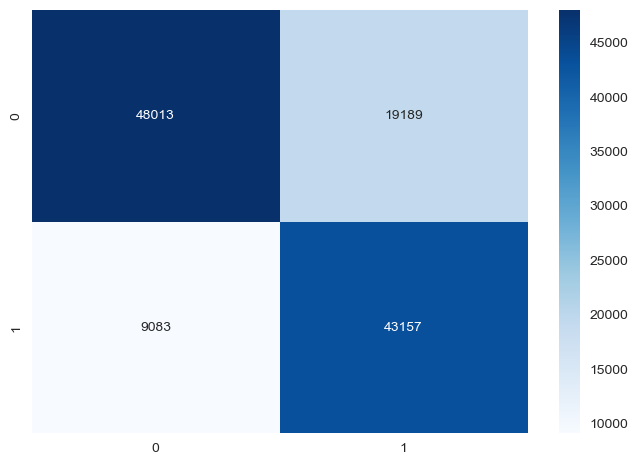

In [86]:
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

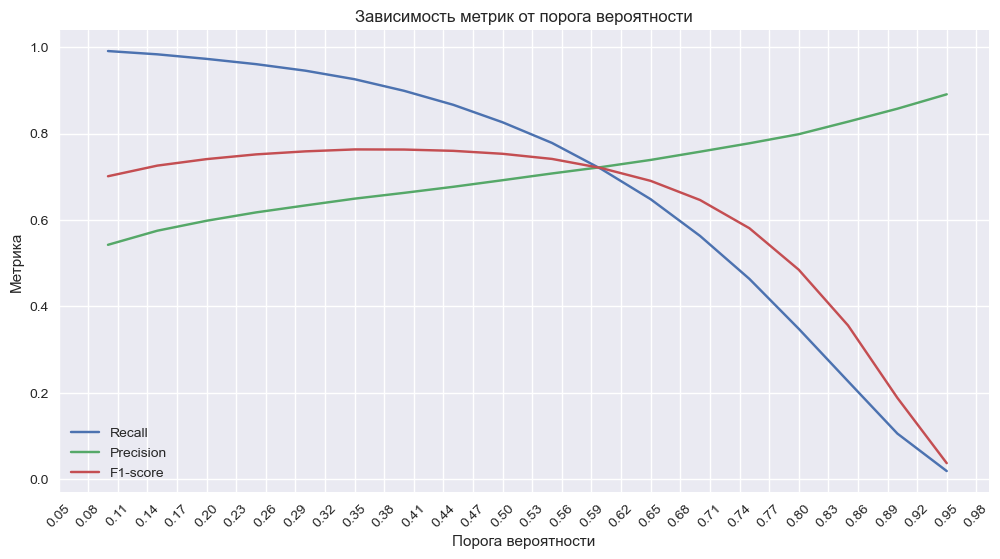

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Нас интересует только вероятность класса (второй столбец)
y_proba_pred = cross_val_predict(pipeline, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(recall_score(y_train, y_pred))
    precision_scores.append(precision_score(y_train, y_pred))
    f1_scores.append(f1_score(y_train, y_pred))
    
# Строим линейный график зависимости recall от threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
plt.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
plt.plot(thresholds, f1_scores, label='F1-score')

plt.title('Зависимость метрик от порога вероятности')
plt.xlabel('Порог вероятности')
plt.ylabel('Метрика')
plt.xticks(thresholds)
plt.xticks(np.arange(0.05, 1, 0.03), rotation=45)
plt.grid(True)
plt.legend()

### 📈 ROC-кривая и матрица ошибок для модели на тестовой выборке (с балансировкой классов)

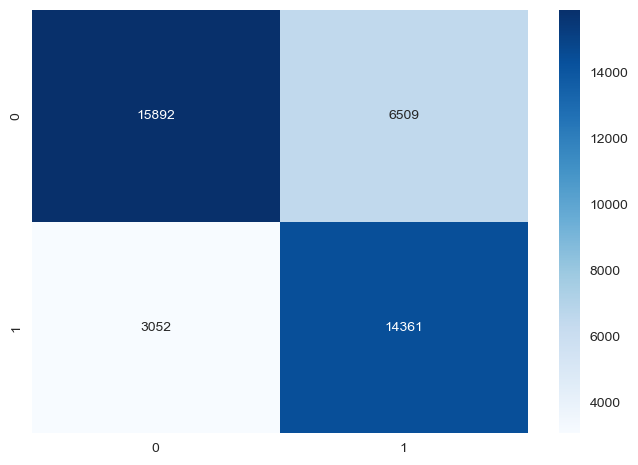

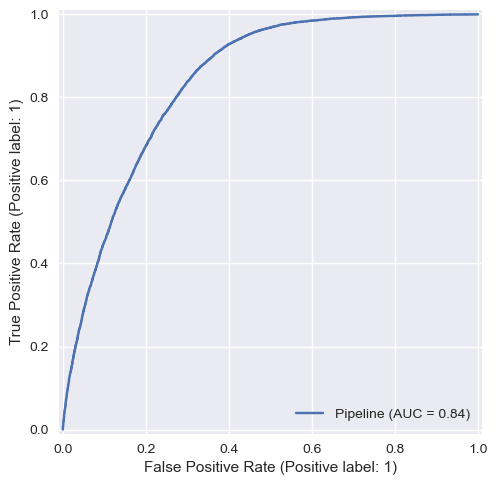

In [87]:
y_pred = pipeline.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

In [88]:
y_true = y_test
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print(f"Accuracy с балансировкой классов: {accuracy_score(y_true, y_pred)}")

scores = precision_recall_fscore_support(y_true, y_pred)
scores = pd.DataFrame(scores, index=['Precision', 'Recall', 'F-Score', 'Support'])
scores['Mean'] = scores.mean('columns')

roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

scores

Accuracy с балансировкой классов: 0.7598583412869845
ROC-AUC: 0.84076976734347


,0,1,Mean
Precision,0.838894,0.688117,0.763505
Recall,0.709433,0.824729,0.767081
F-Score,0.768751,0.750255,0.759503
Support,22401.000000,17413.000000,19907.000000


## Вывод по модели с результатами на валидации и тесте

### 1. Количественная оценка производительности

Модель показывает высокое и стабильное качество на обеих выборках:

- **ROC-AUC**: 0.844 (валидация) → 0.842 (тест) - **снижение на 0.002**
- **F1-Score**: 0.735 (валидация) → 0.759 (тест) - **улучшение на 0.024**

### 2. Анализ стабильности и обобщающей способности

Минимальное изменение метрик ROC-AUC и F1-Score указывает на отсутствие переобучения

### 3. Детальный анализ метрик

**По ROC-AUC:**

- **ROC-AUC = 0.842** на тесте подтверждает, что модель обладает высокой разделяющей способностью

**По F1-Score:**

- **F1-Score = 0.759** на тесте показывает, что модель имеет балансированное качество классификации с хорошим балансом между точностью и полнотой

### 4. Краткий вывод

Высокие и стабильные показатели ROC-AUC, F1-Score демонстрируют, что Baseline-модель достаточно хорошо разделяет классы (**ROC-AUC > 0.8**) и имеет баланс между точностью и полнотой (**F1-Score > 0.75**), из чего можно сделать вывод – Baseline уверенно моделирует целевой признак.